In [2]:
import numpy as np
import pandas as pd

### Brute Force Implementation

#### Step 1: Define the Datasets

In [81]:
data = np.array(
    [
        ["A", 1, 1],
        ["B", 1.5, 2],
        ["C", 3, 4],
        ["D", 5, 7],
        ["E", 3.5, 5],
    ]
)

data_df = pd.DataFrame(data, columns=["Point", "X", "Y"])
data_df

,Point,X,Y
0,A,1,1
1,B,1.5,2
2,C,3,4
3,D,5,7
4,E,3.5,5


In [82]:
X = data_df.iloc[:, 1:4].astype(float).values
X.shape, type(X)

((5, 2), numpy.ndarray)

#### Step 2: Define Hyperparameters

In [83]:
K = 3            # Number of Clusters
init = "random"  # Randomnly choose two data Points as Centroid
n_init = 2       # Number of Times to perform this algorithm. (Helps to minimize bad cluster choice of init parameter)
tol = 1e-3       # Check for Convergence
max_iters = 2    # Number of Iterations to perform

#### Step 3: Run the Iterations

In [84]:
# Test for Multiple Value of K
K_list = [2]
inertias_k = []
silhouette_scores_k = []
for K in K_list:
    print(f"{'='*30}K: {K}{'='*30}")

    res_across_inits = {}
    for init_no in range(n_init): # First loop will be to decide number of times to perform the algorithm
        print(f"{'='*30}Init No: {init_no+1}{'='*30}")

        # Step 1: Initialize Centroids
        if init in ["random", "k-means++"]:
            random_indices = np.random.choice(X.shape[0], size=K, replace=False)
            centroids = X[random_indices]
        else:
            raise ValueError("Invalid value for 'init' parameter")
        
        print(f"\tStep 1: Initial Centroids: {[centroids[i] for i in range (K)]}")
        

        # Step 2: Run K-Means Algorithm
        for iter_no in range(max_iters):

            print(f"\t\tStep 2:  Iteration No: {iter_no + 1}")

            # Step 3: Assign Each point to Nearest centroid
            distances = np.zeros((X.shape[0], K))
            for k in range(K):
                distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
                data_df[f"Distance_to_Centroid_{k}"] = distances[:, k]

            cluster_assignments = np.argmin(distances, axis=1)
            data_df["Cluster"] = cluster_assignments
            print(f"\t\tStep 3: Cluster Assignments:\n\t\t{data_df}")

            # Step 4: Update Centroids
            new_centroids = np.zeros((K, X.shape[1]))
            for k in range(K):
                new_centroids[k] = X[cluster_assignments == k].mean(axis=0)
            print(f"\t\tStep 4: Updated Centroids: {[new_centroids[i] for i in range (K)]}")

            # Step 5: Check for Convergence
            centroid_shifts = np.linalg.norm(new_centroids - centroids, axis=1)
            print(f"\t\tStep 5: Centroid Shifts: {centroid_shifts}")
            if np.all(centroid_shifts <= tol):
                print("Convergence reached.")
                break
            centroids = new_centroids

            print(f"\t\tIteration {iter_no + 1} complete.\n")
        
        
        # Measure Evaluation Metric (Inertia) for this run
        intertia = 0.0 # WCSS - Within Cluster Sum of Squares
        for k in range(K):
            intertia += np.sum((X[cluster_assignments == k] - centroids[k]) ** 2)
        print(f"\tEvaluation Metric (Inertia) for Init no: {init_no + 1} is: {intertia}")

        # Measure Silhouette Score for this run
        silhouette_scores = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            own_cluster = cluster_assignments[i]
            a_i = np.mean(np.linalg.norm(X[cluster_assignments == own_cluster] - X[i], axis=1))
            b_i = np.min([
                np.mean(np.linalg.norm(X[cluster_assignments == k] - X[i], axis=1))
                for k in range(K) if k != own_cluster
            ])
            silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i)
        overall_silhouette_score = np.mean(silhouette_scores)
        print(f"\tEvaluation Metric (Silhouette Score) for Init no: {init_no + 1} is: {overall_silhouette_score}")

        # Update the results across inits
        res_across_inits[init_no] = {
            "centroids": centroids,
            "cluster_assignments": cluster_assignments,
            "inertia": intertia,
            "silhouette_score": overall_silhouette_score
        }
        print(f"K-Means run {init_no + 1} complete.\n")

    # Choose the best run based on Inertia
    best_init_no = min(res_across_inits, key=lambda x: res_across_inits[x]["inertia"])
    best_res = res_across_inits[best_init_no]

    inertias_k.append(best_res["inertia"])
    silhouette_scores_k.append(best_res["silhouette_score"])
    print(f"Best Init No for K={K} is: {best_init_no + 1} with Inertia: {best_res['inertia']} and Silhouette Score: {best_res['silhouette_score']}\n")

==============================K: 2==============================
==============================Init No: 1==============================
	Step 1: Initial Centroids: [array([3., 4.]), array([1.5, 2. ])]
		Step 2:  Iteration No: 1
		Step 3: Cluster Assignments:
		  Point    X  Y  Distance_to_Centroid_0  Distance_to_Centroid_1  Cluster
0     A    1  1                3.605551                1.118034        1
1     B  1.5  2                2.500000                0.000000        1
2     C    3  4                0.000000                2.500000        0
3     D    5  7                3.605551                6.103278        0
4     E  3.5  5                1.118034                3.605551        0
		Step 4: Updated Centroids: [array([3.83333333, 5.33333333]), array([1.25, 1.5 ])]
		Step 5: Centroid Shifts: [1.57233019 0.55901699]
		Iteration 1 complete.

		Step 2:  Iteration No: 2
		Step 3: Cluster Assignments:
		  Point    X  Y  Distance_to_Centroid_0  Distance_to_Centroid_1  Cluster
0     A 

#### Step 4: Plot the Elbow Method

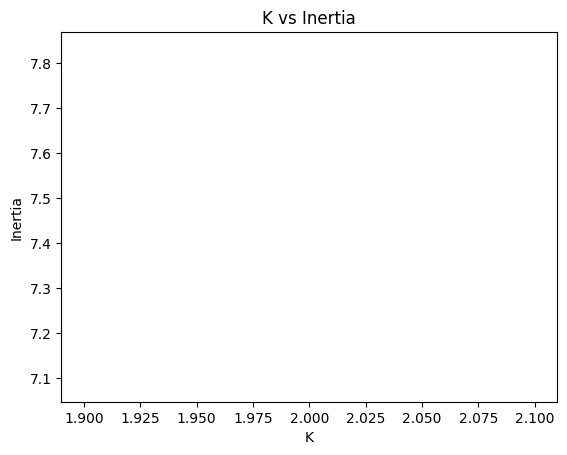

In [85]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(K_list, inertias_k)
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("K vs Inertia")

# Annotate points
# for i, k in enumerate(K_list):
#     plt.annotate(f"{inertias_k[i]:.2f}", (k, inertias_k[i]), textcoords="offset points", xytext=(0,10), ha='right')

# Find the elbow point
if len(K_list) >= 3:
    elbow_k = K_list[np.argmax(np.diff(inertias_k, 2)) + 1]
    plt.axvline(x=elbow_k, color='r', linestyle='--', label='Elbow Point')
    plt.legend()  # Display the legend

plt.show()

#### Step 5: Visualise the clusters

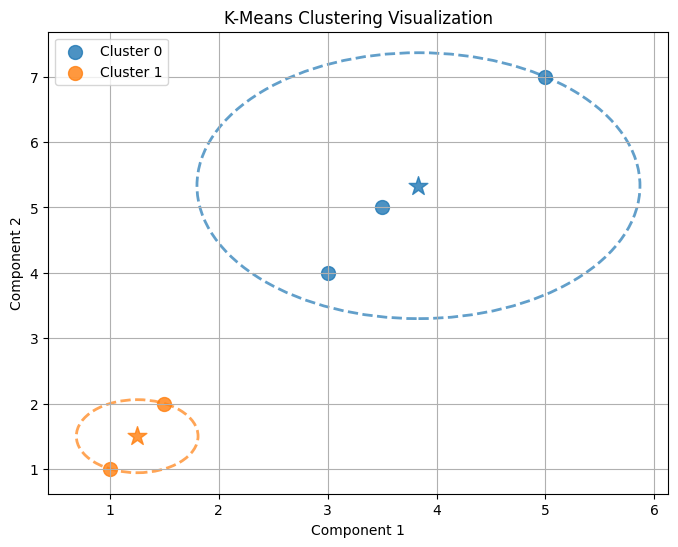

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.patches import Circle

def visualize_clusters(X, cluster_assignments, centroids, random_state=42):
    X = np.asarray(X)
    centroids = np.asarray(centroids)
    labels = np.asarray(cluster_assignments)

    n_samples, n_features = X.shape
    unique_clusters = np.unique(labels)

    # Dimensionality reduction if needed
    if n_features > 2:
        X_all = np.vstack([X, centroids])
        perplexity = min(30, X_all.shape[0] - 1)

        tsne = TSNE(
            n_components=2,
            random_state=random_state,
            perplexity=perplexity
        )
        X_all_vis = tsne.fit_transform(X_all)

        X_vis = X_all_vis[:len(X)]
        centroids_vis = X_all_vis[len(X):]
        title_suffix = " (t-SNE projection)"
    else:
        X_vis = X
        centroids_vis = centroids
        title_suffix = ""

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each cluster
    for cluster_id in unique_clusters:
        mask = labels == cluster_id

        # Plot points
        scatter = ax.scatter(
            X_vis[mask, 0],
            X_vis[mask, 1],
            s=100,
            alpha=0.8,
            label=f"Cluster {cluster_id}"
        )

        # Extract color
        cluster_color = scatter.get_facecolor()[0]

        # Plot centroid as *
        centroid = centroids_vis[cluster_id]
        ax.scatter(
            centroid[0],
            centroid[1],
            s=200,
            marker="*",
            color=cluster_color,
            edgecolor=cluster_color,
            zorder=5
        )

        # Compute radius = max distance to centroid
        distances = np.linalg.norm(X_vis[mask] - centroid, axis=1)
        radius = distances.max() if len(distances) > 0 else 0.0

        # Draw circle
        circle = Circle(
            centroid,
            radius,
            fill=False,
            linestyle="--",
            linewidth=2,
            edgecolor=cluster_color,
            alpha=0.7
        )
        ax.add_patch(circle)

    ax.set_title(f"K-Means Clustering Visualization{title_suffix}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend()
    ax.grid(True)
    plt.show()


cluster_assignments = best_res["cluster_assignments"]
centroids = best_res["centroids"]
visualize_clusters(X, cluster_assignments, centroids)

#### Scikit Learn Implementation

#### Step 1: Define the Dataset

In [3]:
n_sample = 10
n_dim = 2
X = np.random.rand(n_sample, n_dim)

#### Step 2: Define Hyperparameter

In [4]:
from sklearn.cluster import KMeans
params = {
    'n_clusters': 3,
    'init': 'random',
    'n_init': 2,
    'tol': 1e-8,
    'max_iter': 5
}

# Intialise the Model
model = KMeans(**params)

# Fit the model to get centroids and labels
labels = model.fit_predict(X)
centroids = model.cluster_centers_

# Get Inertia
inertia = model.inertia_

# Get Silhouette Score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X, labels)

labels, centroids, inertia, silhouette_avg

(array([1, 1, 2, 0, 2, 0, 1, 0, 0, 1], dtype=int32),
 array([[0.31828829, 0.80280589],
        [0.45851212, 0.31783309],
        [0.89206489, 0.87204474]]),
 0.3956064834762728,
 0.4169683450578557)

#### Step 3: Visualise the cluster

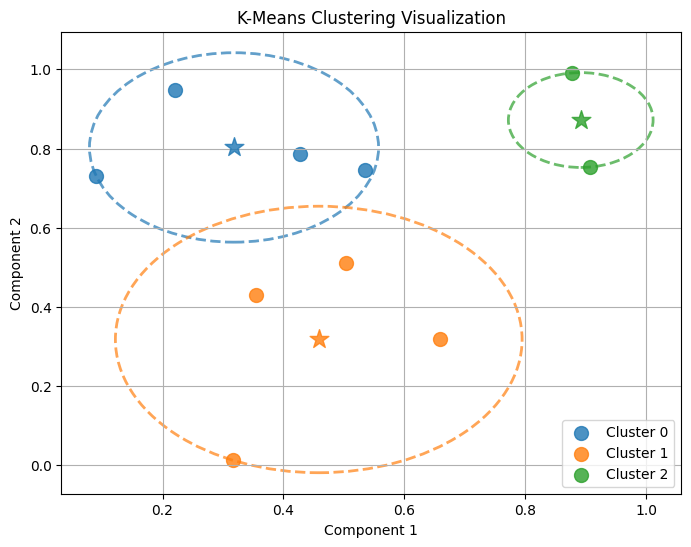

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.patches import Circle

def visualize_clusters(X, cluster_assignments, centroids, random_state=42):
    X = np.asarray(X)
    centroids = np.asarray(centroids)
    labels = np.asarray(cluster_assignments)

    n_samples, n_features = X.shape
    unique_clusters = np.unique(labels)

    # Dimensionality reduction if needed
    if n_features > 2:
        X_all = np.vstack([X, centroids])
        perplexity = min(30, X_all.shape[0] - 1)

        tsne = TSNE(
            n_components=2,
            random_state=random_state,
            perplexity=perplexity
        )
        X_all_vis = tsne.fit_transform(X_all)

        X_vis = X_all_vis[:len(X)]
        centroids_vis = X_all_vis[len(X):]
        title_suffix = " (t-SNE projection)"
    else:
        X_vis = X
        centroids_vis = centroids
        title_suffix = ""

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each cluster
    for cluster_id in unique_clusters:
        mask = labels == cluster_id

        # Plot points
        scatter = ax.scatter(
            X_vis[mask, 0],
            X_vis[mask, 1],
            s=100,
            alpha=0.8,
            label=f"Cluster {cluster_id}"
        )

        # Extract color
        cluster_color = scatter.get_facecolor()[0]

        # Plot centroid as *
        centroid = centroids_vis[cluster_id]
        ax.scatter(
            centroid[0],
            centroid[1],
            s=200,
            marker="*",
            color=cluster_color,
            edgecolor=cluster_color,
            zorder=5
        )

        # Compute radius = max distance to centroid
        distances = np.linalg.norm(X_vis[mask] - centroid, axis=1)
        radius = distances.max() if len(distances) > 0 else 0.0

        # Draw circle
        circle = Circle(
            centroid,
            radius,
            fill=False,
            linestyle="--",
            linewidth=2,
            edgecolor=cluster_color,
            alpha=0.7
        )
        ax.add_patch(circle)

    ax.set_title(f"K-Means Clustering Visualization{title_suffix}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend()
    ax.grid(True)
    plt.show()



visualize_clusters(X, labels, centroids)

#### FAISS Implementation

#### Step 1: Define the Dataset

In [112]:
# n_sample = 10
# n_dim = 2
# X = np.random.rand(n_sample, n_dim)

#### Step 2 Define Hyperparameter

In [6]:
k = 3             # Number of Clusters
d = X.shape[1]    # Dimension of Data Points
nredo = 2         # Number of Times to repeat the clustering
niter = 5         # Number of Iterations
# tol = 1e-3      # FAISS uses fixed stopping
# init = 'random' # FAISS uses random initialization

#### Step 3: Train the K means Clustering model

In [7]:
import faiss

# Intialise the Model
kmeans = faiss.Clustering(d, k)

# Set parameters
kmeans.nredo = nredo
kmeans.niter = niter
kmeans.verbose = False

# Index defines distance metric
index = faiss.IndexFlatL2(d)


# Train the model to get centroids and labels
kmeans.train(X, index)

# Centroids
centroids = faiss.vector_to_array(kmeans.centroids).reshape(k, d)

# Labels
_, cluster_assignments = index.search(X, 1)
labels = cluster_assignments.flatten()

inertia = np.sum([
    np.sum((X[i] - centroids[labels[i]]) ** 2)
    for i in range(d)
])

# Get Silhouette Score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X, labels)

centroids, labels, inertia, silhouette_avg

WARNING clustering 10 points to 3 centroids: please provide at least 117 training points


(array([[0.8920649 , 0.87204474],
        [0.35524148, 0.6920404 ],
        [0.48787645, 0.16515695]], dtype=float32),
 array([2, 1, 0, 1, 0, 1, 2, 1, 1, 1]),
 np.float64(0.12125284071085082),
 0.3357998458340274)

#### Step 4: Visualisation

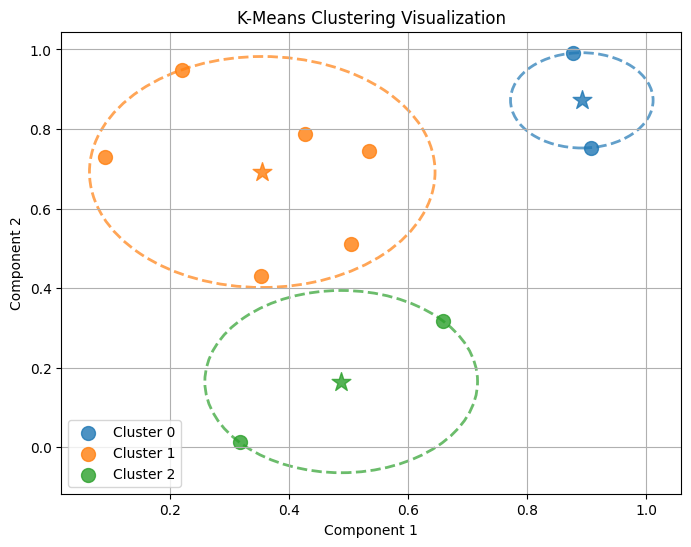

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.patches import Circle

def visualize_clusters(X, cluster_assignments, centroids, random_state=42):
    X = np.asarray(X)
    centroids = np.asarray(centroids)
    labels = np.asarray(cluster_assignments)

    n_samples, n_features = X.shape
    unique_clusters = np.unique(labels)

    # Dimensionality reduction if needed
    if n_features > 2:
        X_all = np.vstack([X, centroids])
        perplexity = min(30, X_all.shape[0] - 1)

        tsne = TSNE(
            n_components=2,
            random_state=random_state,
            perplexity=perplexity
        )
        X_all_vis = tsne.fit_transform(X_all)

        X_vis = X_all_vis[:len(X)]
        centroids_vis = X_all_vis[len(X):]
        title_suffix = " (t-SNE projection)"
    else:
        X_vis = X
        centroids_vis = centroids
        title_suffix = ""

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each cluster
    for cluster_id in unique_clusters:
        mask = labels == cluster_id

        # Plot points
        scatter = ax.scatter(
            X_vis[mask, 0],
            X_vis[mask, 1],
            s=100,
            alpha=0.8,
            label=f"Cluster {cluster_id}"
        )

        # Extract color
        cluster_color = scatter.get_facecolor()[0]

        # Plot centroid as *
        centroid = centroids_vis[cluster_id]
        ax.scatter(
            centroid[0],
            centroid[1],
            s=200,
            marker="*",
            color=cluster_color,
            edgecolor=cluster_color,
            zorder=5
        )

        # Compute radius = max distance to centroid
        distances = np.linalg.norm(X_vis[mask] - centroid, axis=1)
        radius = distances.max() if len(distances) > 0 else 0.0

        # Draw circle
        circle = Circle(
            centroid,
            radius,
            fill=False,
            linestyle="--",
            linewidth=2,
            edgecolor=cluster_color,
            alpha=0.7
        )
        ax.add_patch(circle)

    ax.set_title(f"K-Means Clustering Visualization{title_suffix}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend()
    ax.grid(True)
    plt.show()


visualize_clusters(X, labels, centroids)